In [154]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import numpy as np
import json

In [155]:
# loading the dataset containing pairs of English and German Sentences

NUM_EXAMPLES = 16000
data_examples = []
with open('/content/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [156]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)

    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence.strip()

In [157]:
# Creating separate lists of English and German Sentences
English_sentences=[(i.split("\t"))[0] for i in data_examples]
German_sentences=[(i.split("\t"))[1] for i in data_examples]

In [158]:
# Preprocessing Sentences
English_sentences_preprocessed=[preprocess_sentence(i) for i in English_sentences]
German_sentences_preprocessed=[preprocess_sentence(i) for i in German_sentences]
German_sentences_preprocessed=["<start>"+" "+ preprocess_sentence(i) +" "+ "<end>" for i in German_sentences_preprocessed]

In [159]:
# Creating indexes by Tokenizer, on German Sentences Data

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='',
                      split=' ',
                      char_level=False)

tokenizer.fit_on_texts(German_sentences_preprocessed)
tokenizer_config = tokenizer.get_config()

index_word = json.loads(tokenizer_config['index_word'])
word_index = json.loads(tokenizer_config['word_index'])

In [160]:
# Creating tokens/ sequences from German Sentences
german_seq = tokenizer.texts_to_sequences(German_sentences_preprocessed)
german_seq=np.array(german_seq, dtype=object)

In [161]:
# Priniting Random English Sentences and their German Counterparts
idxs=np.random.randint(0,16000,5)
eng=np.array(English_sentences_preprocessed)[idxs]
ger=np.array(German_sentences_preprocessed)[idxs]
german_seq_=german_seq[idxs]

for i in range(5):
    print(eng[i]+ '-->', ger[i], german_seq_[i])
    print('\n')


are you drinking ?--> <start> trinkst du ? <end> [1, 4508, 14, 7, 2]


i can't deny it .--> <start> ich kann es nicht verleugnen . <end> [1, 4, 31, 10, 12, 3937, 3, 2]


you're drunk .--> <start> du bist blau . <end> [1, 14, 33, 494, 3, 2]


who built it ?--> <start> wer hat es erbaut ? <end> [1, 38, 17, 10, 2161, 7, 2]


take a card .--> <start> nehmen sie eine karte ! <end> [1, 199, 9, 37, 510, 8, 2]




In [162]:
# Padding German Sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_german_seq=pad_sequences(german_seq, maxlen=None,padding='post')
padded_german_seq

array([[   1,  360,    8, ...,    0,    0,    0],
       [   1, 2667,  575, ...,    0,    0,    0],
       [   1, 1197,    8, ...,    0,    0,    0],
       ...,
       [   1,   11,    6, ...,    0,    0,    0],
       [   1,   11,    6, ...,    0,    0,    0],
       [   1,   60, 2414, ...,    0,    0,    0]], dtype=int32)

In [163]:
padded_german_seq.shape

(16000, 14)

In [164]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1",
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [165]:
from tensorflow.keras.models import load_model

In [166]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In [167]:
# Creating random split of training and Validation data
from sklearn.model_selection import train_test_split
X=np.array(English_sentences_preprocessed)
y=padded_german_seq
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20)

In [168]:
# Creating Dataset Objects of Training and Validation Data
train_dataset= tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_dataset= tf.data.Dataset.from_tensor_slices((X_val,y_val))

In [169]:
# Defining the functions that will perform the required dataset processing

def sen_split(Eng_Sen,Ger_Seq):
    Eng_Sen_split=tf.strings.split(Eng_Sen,' ')
    return Eng_Sen_split, Ger_Seq

def word_embed(words,Ger_Seq):
    word_embeddings=embedding_layer(words)
    return word_embeddings, Ger_Seq

def len_filter(word_embeddings,Ger_Seq):
    return int(tf.shape(word_embeddings)[0])<=15

def pad_seq(word_embeddings,Ger_Seq):

    r=15-int(tf.shape(word_embeddings)[0])
    paddings=[[r, 0],
       [0, 0]]
    word_embeddings=tf.pad(word_embeddings, paddings, mode='CONSTANT', constant_values=0.0, name=None)
    return word_embeddings,Ger_Seq

def prepare_dataset(Eng_Seq,Ger_Seq):

    seq_add_padding=tf.concat([Ger_Seq,tf.constant([0],dtype=tf.int32)],axis=0)
    Ger_Outputs_True=seq_add_padding[1:]

    return ((Eng_Seq,Ger_Seq),Ger_Outputs_True)

In [170]:
# Applying the functions defined above
train_dataset=train_dataset.map(sen_split)
val_dataset=val_dataset.map(sen_split)

train_dataset=train_dataset.map(word_embed)
val_dataset=val_dataset.map(word_embed)

train_dataset=train_dataset.filter(len_filter)
val_dataset=val_dataset.filter(len_filter)

train_dataset=train_dataset.map(pad_seq)
val_dataset=val_dataset.map(pad_seq)

train_dataset=train_dataset.map(prepare_dataset)
val_dataset=val_dataset.map(prepare_dataset)

In [171]:
# Batching the Dataset Objects
train_dataset=train_dataset.batch(16)
val_dataset=val_dataset.batch(16)

In [172]:
# Printing the element spec property of Datasets
print(train_dataset.element_spec)
print(val_dataset.element_spec)

((TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
((TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [173]:
# Printing shape of English Data Example from Training Dataset
for elem in train_dataset.take(1):
    print(elem[0][0].shape)

# Printing shape of German Data Example from Validation Dataset
for elem in val_dataset.take(1):
    print(elem[1][0])

(16, 15, 128)
tf.Tensor([  10 2273 4207  525    3    2    0    0    0    0    0    0    0    0], shape=(14,), dtype=int32)


In [174]:
from tensorflow.keras.layers import Layer

In [175]:
# Building the custom layer that adds a learned embedded 'end' token to end of each sequence

class layer_add_learn_embed(Layer):

    def __init__(self):
        super(layer_add_learn_embed, self).__init__()
        self.var=tf.Variable(initial_value=tf.random.normal(shape=[1,1,128]), trainable=True)

    def call(self, input_batch):
        x=input_batch
        x_=tf.tile(self.var,[tf.shape(input_batch)[0],1,1])

        return tf.concat([x,x_],axis=1)

In [176]:
# Shape of English Data Batch Before Custom Layer
for elem in train_dataset.take(1):
    print((elem)[0][0].shape)

(16, 15, 128)


In [177]:
# Creating an Instance of Custom Layer
cust_layer=layer_add_learn_embed()

In [178]:
# Shape of English Data Batch After Custom Layer
for elem in train_dataset.take(1):
    print((cust_layer(elem[0][0])).shape)

(16, 16, 128)


In [179]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [180]:
# Building the encoder using the functional API

inputs=Input(shape=(15,128))
x=cust_layer(inputs)
x=tf.keras.layers.Masking(mask_value=0.0)(x)
_,hidden_state,cell_state=tf.keras.layers.LSTM(units=512, return_sequences=True, return_state=True)(x)
encoder=Model(inputs=inputs,outputs=[hidden_state,cell_state])

In [181]:
encoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 15, 128)]         0         
                                                                 
 layer_add_learn_embed_3 (l  (None, 16, 128)           128       
 ayer_add_learn_embed)                                           
                                                                 
 masking_5 (Masking)         (None, 16, 128)           0         
                                                                 
 lstm_9 (LSTM)               [(None, 16, 512),         1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1312896 (5.01 MB)
Trainable params: 1312896 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [182]:
num_unique_tokens=len(list(word_index.items()))

In [183]:
# Building the Decoder Network using model sub-classing

class Decoder(Model):

    def __init__(self,num_unique_tokens):
        super(Decoder,self).__init__()
        self.embedding_layer=tf.keras.layers.Embedding(input_dim=num_unique_tokens,
                                                       output_dim=128, mask_zero=True)
        self.lstm=tf.keras.layers.LSTM(units=512, return_sequences=True, return_state=True)
        self.dense=tf.keras.layers.Dense(num_unique_tokens,activation=None)

    def call(self, inputs):
        encoder_outputs,decoder_input=inputs

        hidden_state=encoder_outputs[0]
        cell_state=encoder_outputs[1]

        x=self.embedding_layer(decoder_input)
        if hidden_state is None:
            if cell_state is None:
                out_seq, dec_hidden_state, dec_cell_state=self.lstm(x)

        else:
            initial_state = [hidden_state, cell_state]
            out_seq, dec_hidden_state, dec_cell_state=self.lstm(x, initial_state=initial_state)

        x=self.dense(out_seq)

        return x, dec_hidden_state, dec_cell_state

In [184]:
# Creating an instance of Decoder Class
decoder=Decoder(num_unique_tokens=num_unique_tokens)

In [185]:
for elem in train_dataset.take(1):
    batch_1_Eng=elem[0][0]
    batch_1_Ger=elem[0][1]

In [186]:
# Calling encoder
hidden_state_encoder, cell_state_encoder=encoder(batch_1_Eng)

# Calling decoder
output_seq,hidden_state_decoder, cell_state_decoder =decoder([encoder(batch_1_Eng),batch_1_Ger] )

In [187]:
print(output_seq.shape)
print(hidden_state_decoder.shape)
print(cell_state_decoder.shape)

(16, 14, 4992)
(16, 512)
(16, 512)


In [188]:
decoder.summary()

Model: "decoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  638976    
                                                                 
 lstm_10 (LSTM)              multiple                  1312768   
                                                                 
 dense_4 (Dense)             multiple                  2560896   
                                                                 
Total params: 4512640 (17.21 MB)
Trainable params: 4512640 (17.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


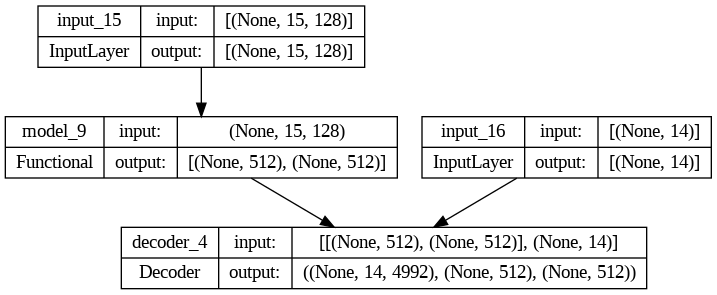

In [189]:
# Building a combined encoder-decoder model and routing the inputs from encoder to decoder

inputs_1=Input(shape=(15,128))
h=encoder(inputs_1)
inputs_2=Input(shape=14)
x=decoder([h,inputs_2])
encoder_decoder=Model(inputs=[inputs_1,inputs_2],outputs=x[0])
tf.keras.utils.plot_model(encoder_decoder, show_shapes=True)

In [ ]:
'''
Model can be trained by a custom training loop as well, as defined below,

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sparse_categorical_accuracy=tf.keras.metrics.SparseCategoricalAccuracy()

# Defining function which generates inputs for German Data and True/ Expected Corresponding Outputs
def Ger_inputs_and_outputs(batch_Ger):
    batch_Ger_inputs=batch_Ger

    for i in range(batch_Ger.shape[0]):
        seq_add_padding=tf.concat([batch_Ger[i],tf.constant([0],dtype=tf.int32)],axis=0)
        seq_out_true=seq_add_padding[1:]
        seq_out_true=tf.expand_dims(seq_out_true,axis=0)

        if i==0:
            batch_Ger_outputs_true=seq_out_true
        else:
            batch_Ger_outputs_true=tf.concat([batch_Ger_outputs_true,seq_out_true],axis=0)

    return batch_Ger_inputs, batch_Ger_outputs_true



# Defining function which performs the forward and backward pass

@tf.function
def forward_and_backward_pass (batch_Eng,batch_Ger_inputs,batch_Ger_outputs_true):

    with tf.GradientTape() as tape:
        loss_value=loss(batch_Ger_outputs_true, encoder_decoder([batch_Eng,batch_Ger_inputs]))
        acc=sparse_categorical_accuracy(batch_Ger_outputs_true,encoder_decoder([batch_Eng,batch_Ger_inputs]))
    return loss_value, acc, tape.gradient(loss_value, encoder_decoder.trainable_variables)




# Defining Custom Training Loop

def train_neural_translation_model(encoder_decoder_model,num_epochs,
                                   training_dataset,validation_dataset, validation_batches, optimizer_obj, grad_fn):

    train_loss_results=[]
    val_loss_results=[]
    train_accuracy_results=[]
    val_accuracy_results=[]

    for epoch in range(num_epochs):

        train_loss_batch_wise=[]
        train_acc_batch_wise=[]

        for x,y in training_dataset:
            Ger_inputs,Ger_outputs_true=Ger_inputs_and_outputs(y)
            train_loss,train_acc, grads= grad_fn(x,Ger_inputs,Ger_outputs_true)
            train_loss_batch_wise.append(train_loss)
            train_acc_batch_wise.append(train_acc)
            optimizer.apply_gradients(zip(grads, (encoder_decoder_model.trainable_variables)))

        epoch_training_loss=np.mean(train_loss_batch_wise)
        epoch_training_acc=np.mean(train_acc_batch_wise)
        train_loss_results.append(epoch_training_loss)
        train_accuracy_results.append(epoch_training_acc)

        val_loss_batch_wise=[]
        val_acc_batch_wise=[]

        for x,y in validation_dataset.take(validation_batches):
          Ger_inputs,Ger_outputs_true=Ger_inputs_and_outputs(y)
          pred_logits=encoder_decoder([x,Ger_inputs])
          val_loss=loss(Ger_outputs_true,pred_logits )
          val_loss_batch_wise.append(val_loss)
          val_acc=sparse_categorical_accuracy(Ger_outputs_true,pred_logits)
          val_acc_batch_wise.append(val_acc)

        epoch_val_loss=np.mean(val_loss_batch_wise)
        epoch_val_acc=np.mean(val_acc_batch_wise)
        val_loss_results.append(epoch_val_loss)
        val_accuracy_results.append(epoch_val_acc)


        print('Epoch {:03d}: Training Loss {:.3f}: '
        'Sparse_Categorical_Training_Accuracy {:.3f}: '
        'Val_Loss {:.3f}:  Sparse_Categorical_Val_Accuracy {:.3f}'
        ':'.format(epoch, epoch_training_loss,epoch_training_acc,epoch_val_loss,epoch_val_acc )  )

    return train_loss_results,train_accuracy_results,val_loss_results,val_accuracy_results

'''

In [191]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [192]:
# Creating an earlystopping callback object
early_stopping=EarlyStopping(monitor='val_loss', patience=2 ,
                             min_delta= 0.005 )

# Creating Reduce Learning Rate on Plateau Object
reduce_lr=ReduceLROnPlateau(monitor="loss",factor=0.8, verbose=0, patience=2,min_delta=0.005)

# Creating Model Checkpoint Callback Object which will save the model weights
# Correspoding to best val loss
checkpoint=ModelCheckpoint('my_model_weights',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss')

# Instantiating Optimizer Object

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [193]:
# Training the model on Training Data

encoder_decoder.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['sparse_categorical_accuracy'])
history=encoder_decoder.fit(train_dataset,epochs=16,validation_data=val_dataset,validation_steps=10,callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/16
800/800 [==============================] - 116s 134ms/step - loss: 3.3064 - sparse_categorical_accuracy: 0.4926 - val_loss: 2.8189 - val_sparse_categorical_accuracy: 0.5653 - lr: 5.0000e-04
Epoch 2/16
800/800 [==============================] - 78s 97ms/step - loss: 2.4511 - sparse_categorical_accuracy: 0.5941 - val_loss: 2.6138 - val_sparse_categorical_accuracy: 0.5978 - lr: 5.0000e-04
Epoch 3/16
800/800 [==============================] - 58s 73ms/step - loss: 2.1132 - sparse_categorical_accuracy: 0.6253 - val_loss: 2.5026 - val_sparse_categorical_accuracy: 0.6219 - lr: 5.0000e-04
Epoch 4/16
800/800 [==============================] - 68s 85ms/step - loss: 1.8422 - sparse_categorical_accuracy: 0.6514 - val_loss: 2.4198 - val_sparse_categorical_accuracy: 0.6284 - lr: 5.0000e-04
Epoch 5/16
800/800 [==============================] - 71s 88ms/step - loss: 1.6165 - sparse_categorical_accuracy: 0.6733 - val_loss: 2.3530 - val_sparse_categorical_accuracy: 0.6413 - lr: 5.0000e-04
Epo

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [206]:
idxs=np.random.randint(0,2000,5)
eng_test=np.array(English_sentences_preprocessed)[idxs]
ger_test=np.array(German_sentences_preprocessed)[idxs]
german_seq_=german_seq[idxs]

In [207]:
def pad_seq_eng_embed(word_embeddings):

    r=15-int(tf.shape(word_embeddings)[0])
    paddings=[[r, 0],
       [0, 0]]
    word_embeddings=tf.pad(word_embeddings, paddings, mode='CONSTANT', constant_values=0.0, name=None)
    return word_embeddings

In [208]:
def get_translation(eng_sen):

  split_eng_sen=tf.strings.split(eng_sen,' ')
  eng_embed=embedding_layer(split_eng_sen)
  eng_embed=pad_seq_eng_embed(eng_embed)
  eng_embed=tf.expand_dims(eng_embed,axis=0)
  encoder_out=encoder_decoder.layers[1](eng_embed)

  hidden_state, cell_state=encoder_out
  input_token= tf.constant([[1]],dtype=tf.int32)

  for i in range(14):
    logits, upd_hidden_state, upd_cell_state=encoder_decoder.layers[3]( ([hidden_state, cell_state] ,input_token )  )
    pred_token = tf.argmax(logits,axis=2)

    if i==0:
      pred_ger_tokens=pred_token
    else:
      pred_ger_tokens=tf.concat([pred_ger_tokens,pred_token], axis=0)

    if int(tf.squeeze(pred_token))==2:
      break

    hidden_state, cell_state=upd_hidden_state, upd_cell_state
    input_token=pred_token

  return ' '.join(tokenizer.sequences_to_texts(pred_ger_tokens.numpy())[:-1])

In [209]:
# Using the model to get translation

for i in range(5):
  print('Eng Sentence : ', eng_test[i])
  print('Correct German Translation : ',ger_test[i] )
  print('Translation by Model :',get_translation(eng_test[i]) )
  print('\n')

Eng Sentence :  i love it !
Correct German Translation :  <start> ich liebe es ! <end>
Translation by Model : ich mag es .


Eng Sentence :  time is up .
Correct German Translation :  <start> die zeit ist um . <end>
Translation by Model : die sommer ist um .


Eng Sentence :  be discreet .
Correct German Translation :  <start> seid diskret ! <end>
Translation by Model : seid diskret !


Eng Sentence :  i'm thin .
Correct German Translation :  <start> ich bin duenn . <end>
Translation by Model : ich bin verkatert .


Eng Sentence :  i hate bugs .
Correct German Translation :  <start> ich hasse insekten . <end>
Translation by Model : ich hasse beerdigungen .


